In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT

In [2]:
spark_session = SparkSession.builder.appName('simple_statistics').getOrCreate()

Loading the data

In [3]:
df = spark_session.read.csv('data/StudentsPerformance.csv', header = True)

In [4]:
df.columns

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course',
 'math score',
 'reading score',
 'writing score']

Categorical variables

In [5]:
df.select('gender').distinct().collect()

[Row(gender='female'), Row(gender='male')]

In [6]:
df.select('race/ethnicity').distinct().collect()

[Row(race/ethnicity='group B'),
 Row(race/ethnicity='group C'),
 Row(race/ethnicity='group D'),
 Row(race/ethnicity='group A'),
 Row(race/ethnicity='group E')]

In [7]:
df.select('parental level of education').distinct().collect()

[Row(parental level of education='some high school'),
 Row(parental level of education="associate's degree"),
 Row(parental level of education='high school'),
 Row(parental level of education="bachelor's degree"),
 Row(parental level of education="master's degree"),
 Row(parental level of education='some college')]

In [8]:
df.select('lunch').distinct().collect()

[Row(lunch='free/reduced'), Row(lunch='standard')]

In [9]:
df.select('test preparation course').distinct().collect()

[Row(test preparation course='completed'), Row(test preparation course='none')]

Numerical variables

In [10]:
math = df.select(df['math score'].cast('float').alias('math'))
mean = math.select(F.mean(math.math).alias('mean')).collect()[0]['mean']
std = math.select(F.stddev(math.math).alias('mean')).collect()[0]['mean']
min_ = math.select(F.min(math.math).alias('min')).collect()[0]['min']
max_ = math.select(F.max(math.math).alias('max')).collect()[0]['max']
print('Math: mean = ' + str(mean) + ', std = ' + str(std) + ', min = ' + str(min_) + ', max = ' + str(max_))

Math: mean = 66.089, std = 15.163080096009454, min = 0.0, max = 100.0


In [11]:
reading = df.select(df['reading score'].cast('float').alias('reading'))
mean = reading.select(F.mean(reading.reading).alias('mean')).collect()[0]['mean']
std = reading.select(F.stddev(reading.reading).alias('mean')).collect()[0]['mean']
min_ = reading.select(F.min(reading.reading).alias('min')).collect()[0]['min']
max_ = reading.select(F.max(reading.reading).alias('max')).collect()[0]['max']
print('Reading: mean = ' + str(mean) + ', std = ' + str(std) + ', min = ' + str(min_) + ', max = ' + str(max_))

Reading: mean = 69.169, std = 14.600191937252223, min = 17.0, max = 100.0


In [12]:
writing = df.select(df['writing score'].cast('float').alias('writing'))
mean = writing.select(F.mean(writing.writing).alias('mean')).collect()[0]['mean']
std = writing.select(F.stddev(writing.writing).alias('mean')).collect()[0]['mean']
min_ = writing.select(F.min(writing.writing).alias('min')).collect()[0]['min']
max_ = writing.select(F.max(writing.writing).alias('max')).collect()[0]['max']
print('Writing: mean = ' + str(mean) + ', std = ' + str(std) + ', min = ' + str(min_) + ', max = ' + str(max_))

Writing: mean = 68.054, std = 15.19565701086966, min = 10.0, max = 100.0


## Transforming variables

Let's transform the categorical variables into numerical ones.

In [13]:
# First we create an autoincrement id column
df = df.withColumn('id', F.monotonically_increasing_id())

In [14]:
for c in ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']:
    categories = df.select(c).distinct().rdd.flatMap(lambda x: x).collect()
    categories = categories[:-1]

    exprs = [F.when(F.col(c) == category, 1).otherwise(0).alias(category)
             for category in categories]

    df = df.join(df.select('id', *exprs), on = 'id').drop(c)

In [15]:
df = df.drop('id')

In [16]:
df.show(10)

+----------+-------------+-------------+------+-------+-------+-------+-------+----------------+------------------+-----------+-----------------+---------------+------------+---------+
|math score|reading score|writing score|female|group B|group C|group D|group A|some high school|associate's degree|high school|bachelor's degree|master's degree|free/reduced|completed|
+----------+-------------+-------------+------+-------+-------+-------+-------+----------------+------------------+-----------+-----------------+---------------+------------+---------+
|        69|           54|           55|     0|      1|      0|      0|      0|               0|                 0|          0|                0|              0|           0|        0|
|        62|           70|           75|     1|      0|      0|      1|      0|               0|                 0|          0|                0|              1|           0|        0|
|        90|           90|           91|     1|      1|      0|      0|    

And now we normalise all the variables:

In [17]:
for c in df.columns:
    values = df.select(df[c].cast('float').alias('values'))
    mean = values.select(F.mean(values.values).alias('mean')).collect()[0]['mean']
    std = values.select(F.stddev(values.values).alias('mean')).collect()[0]['mean']
    
    normalise_udf = F.udf(lambda x: (float(x) - mean) / std, T.FloatType())
    df = df.withColumn(c, normalise_udf(c))

In [18]:
df.show(10)

+-----------+-------------+-------------+----------+----------+-----------+----------+----------+----------------+------------------+-----------+-----------------+---------------+------------+----------+
| math score|reading score|writing score|    female|   group B|    group C|   group D|   group A|some high school|associate's degree|high school|bachelor's degree|master's degree|free/reduced| completed|
+-----------+-------------+-------------+----------+----------+-----------+----------+----------+----------------+------------------+-----------+-----------------+---------------+------------+----------+
| 0.19197947|   -1.0389589|  -0.85906124|-1.0361536|  2.063709|-0.68407625|-0.5955321|-0.3124054|     -0.46669987|        -0.5339117|  -0.493495|      -0.36558592|    -0.25027296|  -0.7415101|-0.7463744|
|-0.26966816|   0.05691706|    0.4571043|0.96414286|-0.4840799|-0.68407625| 1.6774913|-0.3124054|     -0.46669987|        -0.5339117|  -0.493495|      -0.36558592|      3.9916418|  -0.

## Dimensionality reduction

Let's apply PCA to visualise the data and to determine whether there are clearly separable groups. 

In [19]:
features = df.select(F.udf(Vectors.dense, VectorUDT())(*df.columns)).toDF('features')

In [20]:
pca = PCA(k = 2, inputCol = 'features', outputCol = 'pca_features')
model = pca.fit(features)

result = model.transform(features).select('pca_features')
result.show()

+--------------------+
|        pca_features|
+--------------------+
|[1.16630763279792...|
|[-0.7957461807435...|
|[-2.9419046641828...|
|[0.54897914339700...|
|[0.80905445453127...|
|[-1.7091749120609...|
|[0.46123016074257...|
|[-1.5304088515299...|
|[0.61575626145953...|
|[1.19392018305941...|
|[0.18687765950186...|
|[-0.7896917056553...|
|[-0.9000564789971...|
|[-2.1497117347152...|
|[1.87518579908031...|
|[-0.5693422363127...|
|[0.77359048478783...|
|[0.81138938555802...|
|[0.67322040303788...|
|[0.24657525291702...|
+--------------------+
only showing top 20 rows



In [21]:
pca_proj = result.collect()
x = []
y = []
for v in pca_proj:
    x.append(v[0][0])
    y.append(v[0][1])

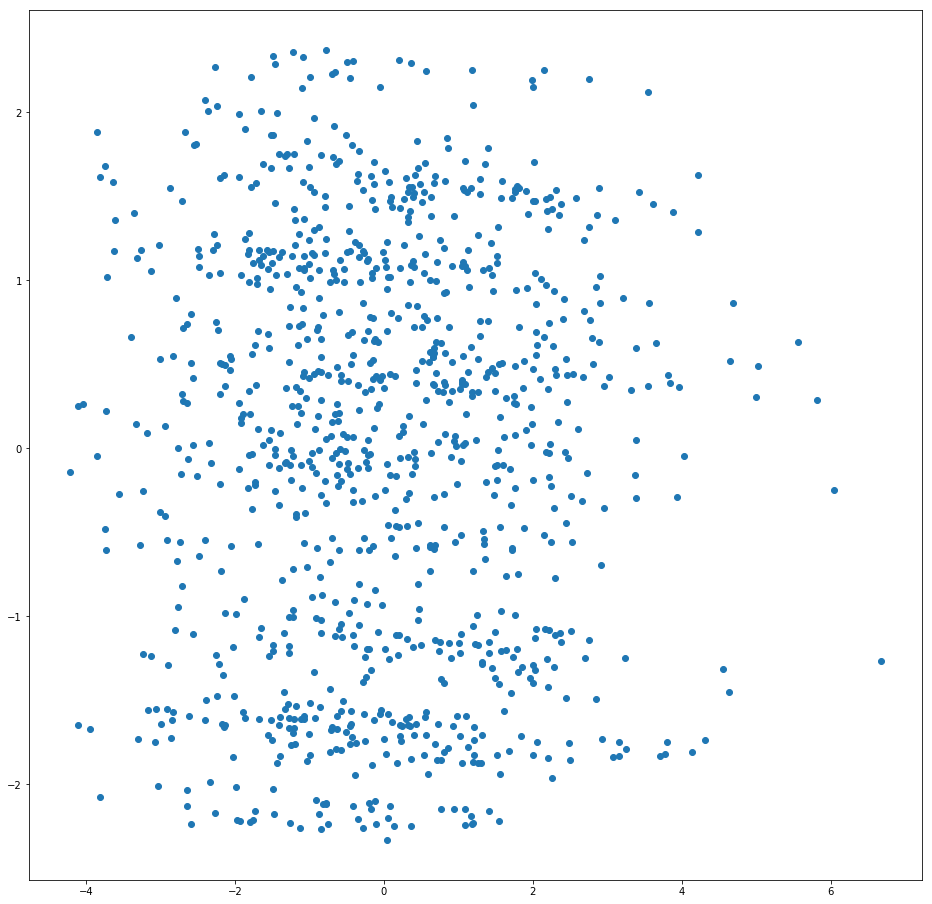

In [22]:
fig, ax = plt.subplots()
ax.plot(x, y, 'o')
fig.set_figwidth(16)
fig.set_figheight(16)

## K-means

There does not seem to be clearly separable clusters in the data. Let's apply k-means anyway for the sake of practice.

In [23]:
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(features)

In [24]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-0.29412141 -0.30786189 -0.35403818 -0.22704489 -0.4840799  -0.68407625
 -0.59553212  3.19776773  0.236382   -0.1555959   0.01572937  0.05214697
 -0.10728707  0.10338191 -0.02019254]
[ 0.33242782  0.48943293  0.54159886  0.28502988 -0.26390061  1.05000775
 -0.59553212 -0.31240541 -0.08043884 -0.53391171 -0.49349499  0.97313627
  0.16868158 -0.10972442  0.20596207]
[-0.16001222 -0.20529884 -0.27107014 -0.05375946  0.16417409  0.10264129
 -0.03063872 -0.31240541 -0.46669987 -0.53391171  2.02433658 -0.36558592
 -0.25027296 -0.04937634 -0.16656553]
[ 0.57196046  0.5798906   0.62470013  0.08550799 -0.11500767 -0.68407625
  0.85962774 -0.31240541  0.31304202 -0.53391171 -0.48172942 -0.03260335
  0.40385408 -0.23396074  0.14991398]
[ 0.37732075  0.40843189  0.41890523  0.11344209 -0.05944841  0.19095377
 -0.072998   -0.31240541 -0.46669987  1.8710959  -0.49349499 -0.36558592
 -0.25027296 -0.15329585  0.14028369]
[-0.98274888 -1.10602427 -1.13017763 -0.2860424   0.48461068 -

In [25]:
# Obtaining the cluster centers
prediction = model.transform(features).select('prediction').collect()
labels = [p.prediction for p in prediction]

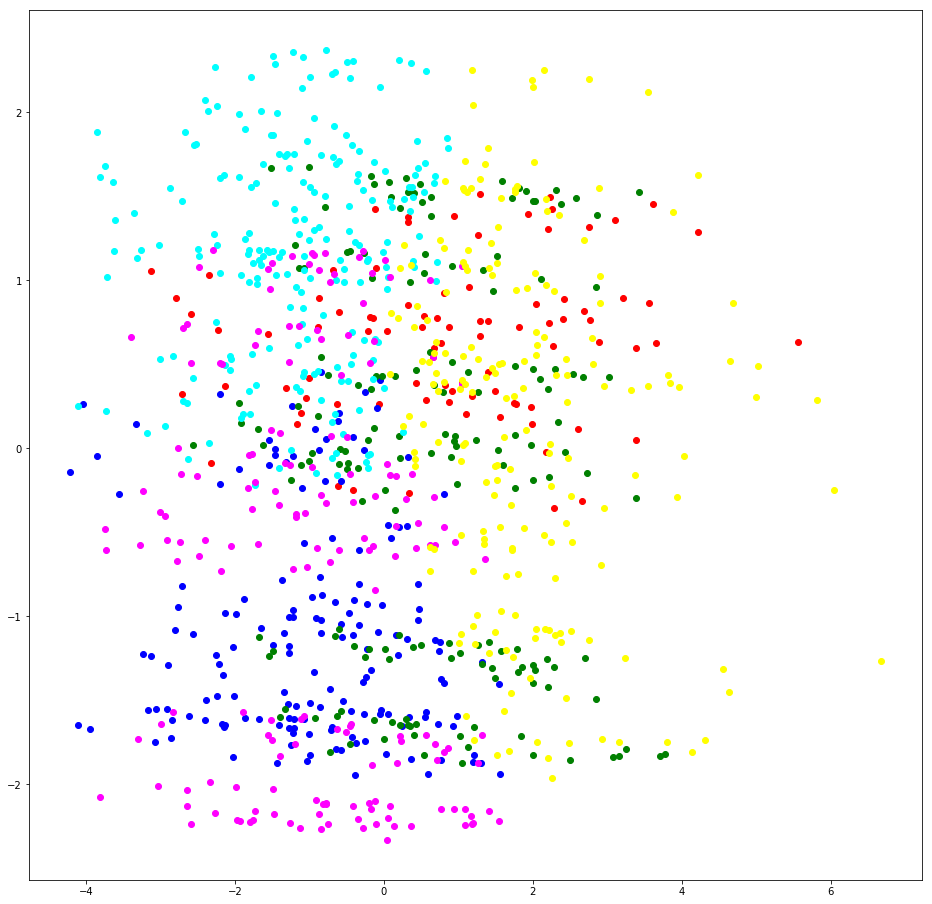

In [26]:
fig, ax = plt.subplots()
x = np.array(x)
y = np.array(y)
colors = ['red', 'blue', 'green', 'cyan', 'magenta', 'yellow']
for l in np.unique(labels):
    ind = labels == l
    ax.plot(x[ind], y[ind], 'o', color = colors[l])
fig.set_figwidth(16)
fig.set_figheight(16)